# Stacked Regressions to predict House Prices 

Goal of this notebook: join [House Prices - Advanced Regression Techniques][1] competition of Kaggle. In this notebook, I will explore data analysis, process data and model using Stacked Regressions and predict price for each house id in test data set. Because submissions are evaluated on Root-Mean-Squared-Error (RMSE) so RMSE will be the metric for the model. 

[1]: https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview/evaluation

Reference notebook

1. [Comprehensive data exploration with Python][1] by **Pedro Marcelino**  

2. [A study on Regression applied to the Ames dataset][2] by **Julien Cohen-Solal**  

3. [Regularized Linear Models][3] by **Alexandru Papiu**  : Great Starter kernel on modelling and Cross-validation
4. [Stacked Regressions : Top 4% on LeaderBoard][4] by **Serigne**

  [1]: https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python
  [2]:https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset
  [3]: https://www.kaggle.com/apapiu/regularized-linear-models
  [4]: https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard

## 1.EDA

In [12]:
#import some necessary librairies

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt  
import seaborn as sns
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)
from scipy import stats
from scipy.stats import norm, skew #for some statistics
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points

In [26]:
#Now let's import and put the train and test datasets in  pandas dataframe

train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')


In [3]:
##display the first five rows of the train dataset.
train.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.000,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
##display the first five rows of the test dataset.
test.head(5)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.000,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.000,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.000,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.000,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.000,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [74]:
#check the numbers of train data and test data
print("The train data size: {} ".format(train.shape))
print("The test data size : {} ".format(test.shape))
#seperate target and feature column 
X = train.drop(['SalePrice'], axis=1)
y = train['SalePrice']
#concatenate the train and test data in the same dataframe
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

The train data size: (1460, 81) 
The test data size : (1459, 80) 
all_data size is : (2919, 80)


###  1.1  Analysing 'SalePrice'

In [8]:
train['SalePrice'].describe()

count     1460.000
mean    180921.196
std      79442.503
min      34900.000
25%     129975.000
50%     163000.000
75%     214000.000
max     755000.000
Name: SalePrice, dtype: float64

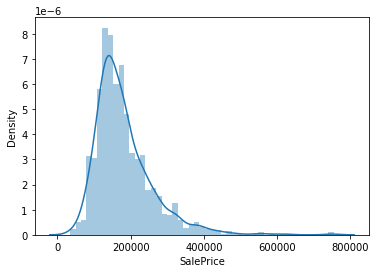

In [13]:
#histogram
sns.distplot(train['SalePrice']);

Comment on saleprice distribution
1. Deviate from the normal distribution.
2. Have appreciable positive skewness.
3. Show peakedness.

In [15]:
#skewness and kurtosis
print("Skewness: %f" % train['SalePrice'].skew())
print("Kurtosis: %f" % train['SalePrice'].kurt())

Skewness: 1.882876
Kurtosis: 6.536282


#### Relationship between saleprice with numerical variables

In [51]:
#find top 20 feature that have highest correlation with SalePrice
corrmat = train.corr()['SalePrice'].nlargest(21)
corrmat

SalePrice      1.000
OverallQual    0.791
GrLivArea      0.709
GarageCars     0.640
GarageArea     0.623
TotalBsmtSF    0.614
1stFlrSF       0.606
FullBath       0.561
TotRmsAbvGrd   0.534
YearBuilt      0.523
YearRemodAdd   0.507
GarageYrBlt    0.486
MasVnrArea     0.477
Fireplaces     0.467
BsmtFinSF1     0.386
LotFrontage    0.352
WoodDeckSF     0.324
2ndFlrSF       0.319
OpenPorchSF    0.316
HalfBath       0.284
LotArea        0.264
Name: SalePrice, dtype: float64

**I decide to further analysis on 4 numerical  features that have highest correlation OverallQual ,  GrLivArea, GarageArea, TotalBsmtSF, 
1stFlrSF, TotRmsAbvGrd**

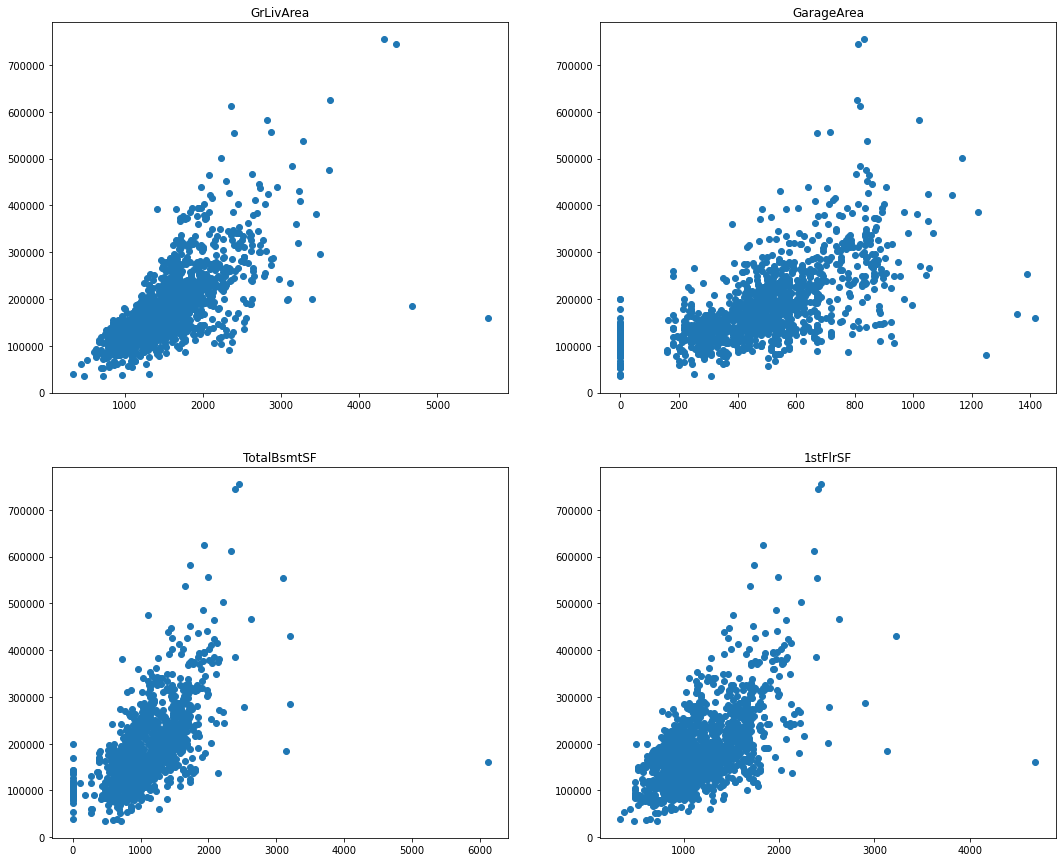

In [61]:
num_feature_list = [  'GrLivArea', 'GarageArea', 'TotalBsmtSF', 
'1stFlrSF']
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2, figsize=(18,15))
ax_list= [ax1,ax2,ax3,ax4]
#scatter plot 
for i in range(4): 
    ax_list[i].scatter(x = train[num_feature_list[i]], y = train['SalePrice'])
    ax_list[i].set_title(num_feature_list[i])

**Comment: we can see that there are certain outliers in 4 plot**

#### Relationship with categorical features

According to top 20 feature that have highest correlation with SalePrice, I choose 4 categorical feature: OverallQual, GarageCars, TotRmsAbvGr
FullBath to further analysis

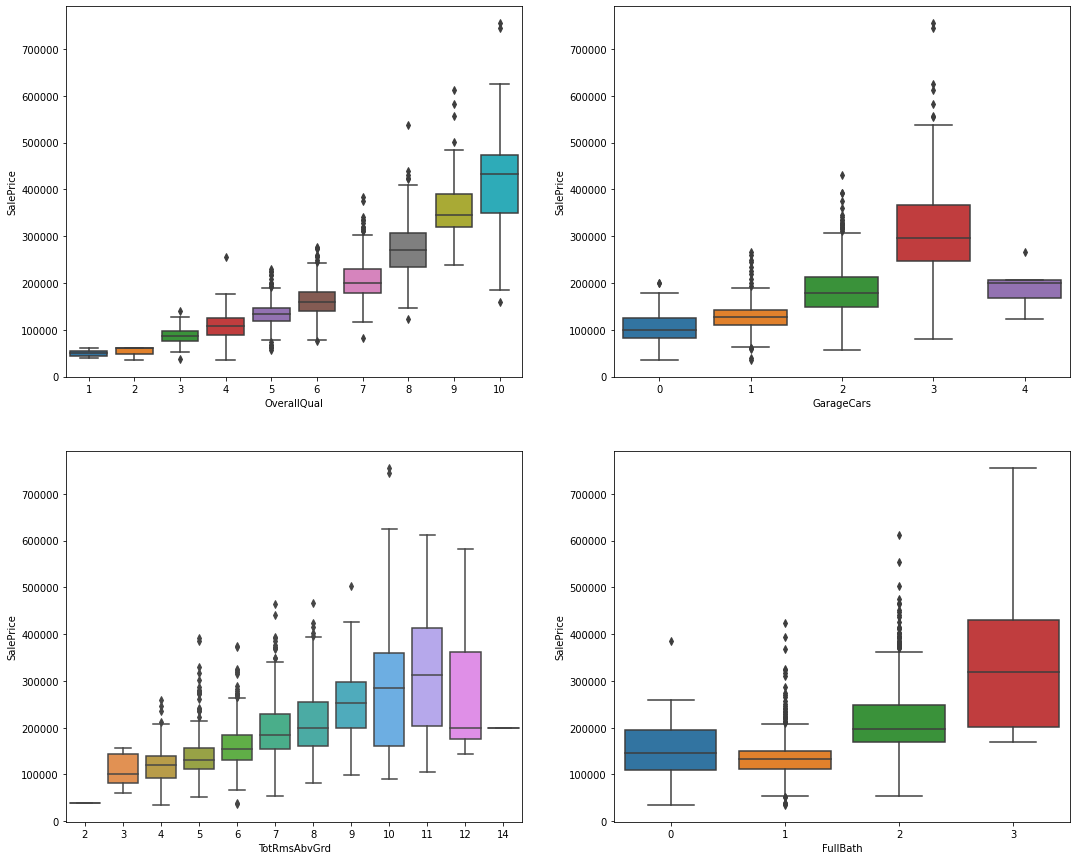

In [69]:
## Box plot
con_feature_list = [ 'OverallQual', 'GarageCars', 'TotRmsAbvGrd',
'FullBath', 'YearBuilt' , 'YearRemodAdd']
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2, figsize=(18,15))
ax_list= [ax1,ax2,ax3,ax4]
for i in range(4): 
    sns.boxplot(ax=ax_list[i], x=con_feature_list[i], y="SalePrice", data=train[['SalePrice',con_feature_list[i]]])    
    #ax_list[i].set_title(con_feature_list[i])


Comment: 
1. We can see strong relationship between OverallQual and Saleprice, increase OverallQual will increase saleprice
2. Houses with Garage Car = 3 seem have higher price.
3. Houses with fullbath = 3 seem have higher price.

### 1.2. Correlation matrix

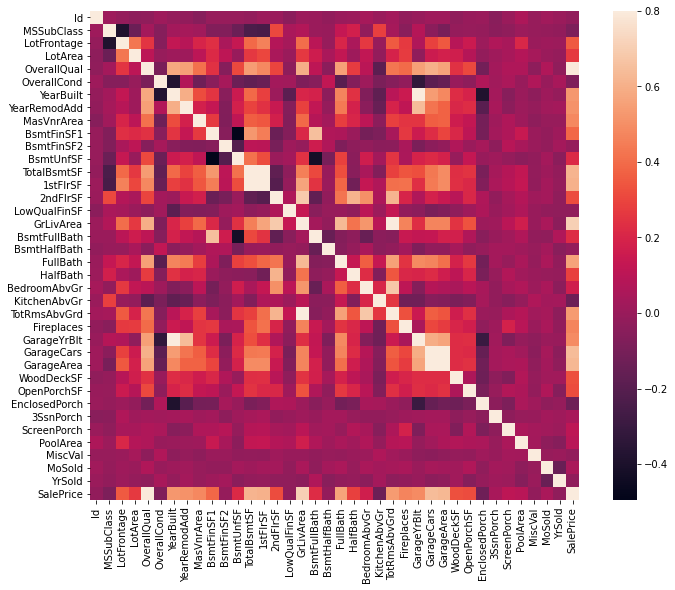

In [71]:
#correlation matrix
corrmat = train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

Comment : Look at the relationship with 'TotalBsmtSF' and '1stFlrSF' variables, 'TotalBsmtSF' and  'GarageX' variables. Both cases show how significant the correlation is between these variables. This correlation is so strong that it can indicate a situation of multicollinearity. If we think about these variables, we can conclude that they give almost the same information so multicollinearity really occurs.

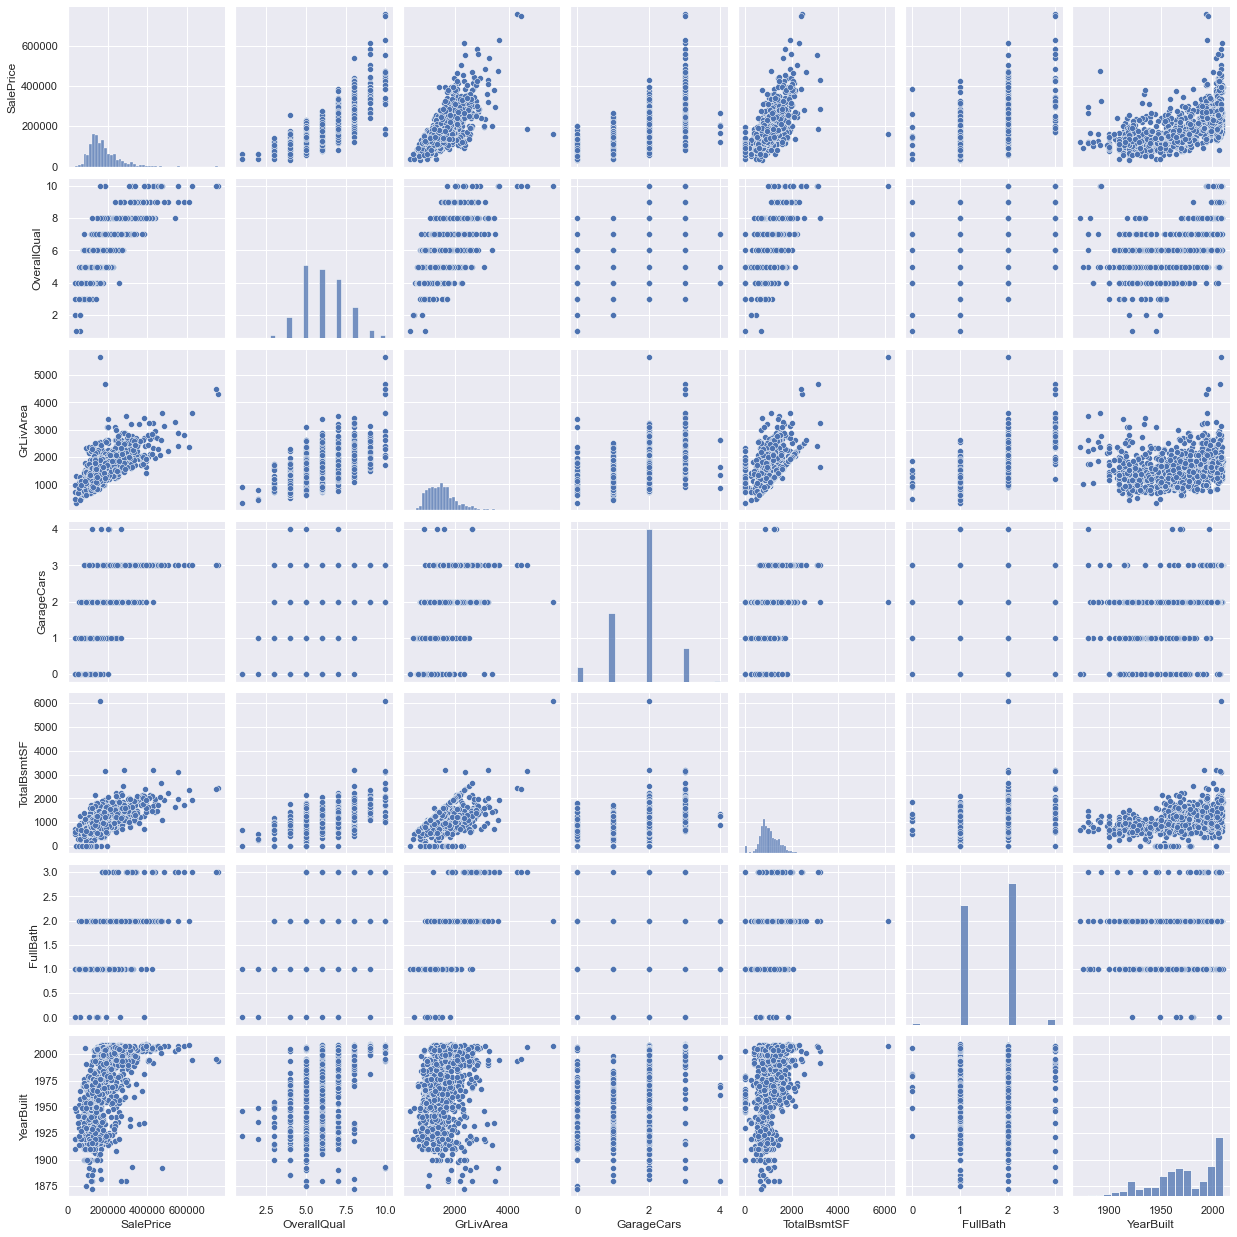

In [73]:
#sns pairplot with several feature that have highest correlation
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(train[cols], size = 2.5)
plt.show();

### 1.3. Missing value

In [78]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data

,Missing Ratio
PoolQC,99.657
MiscFeature,96.403
Alley,93.217
Fence,80.439
FireplaceQu,48.647
LotFrontage,16.650
GarageFinish,5.447
GarageQual,5.447
GarageCond,5.447
GarageYrBlt,5.447


Text(0.5, 1.0, 'Percent missing data by feature')

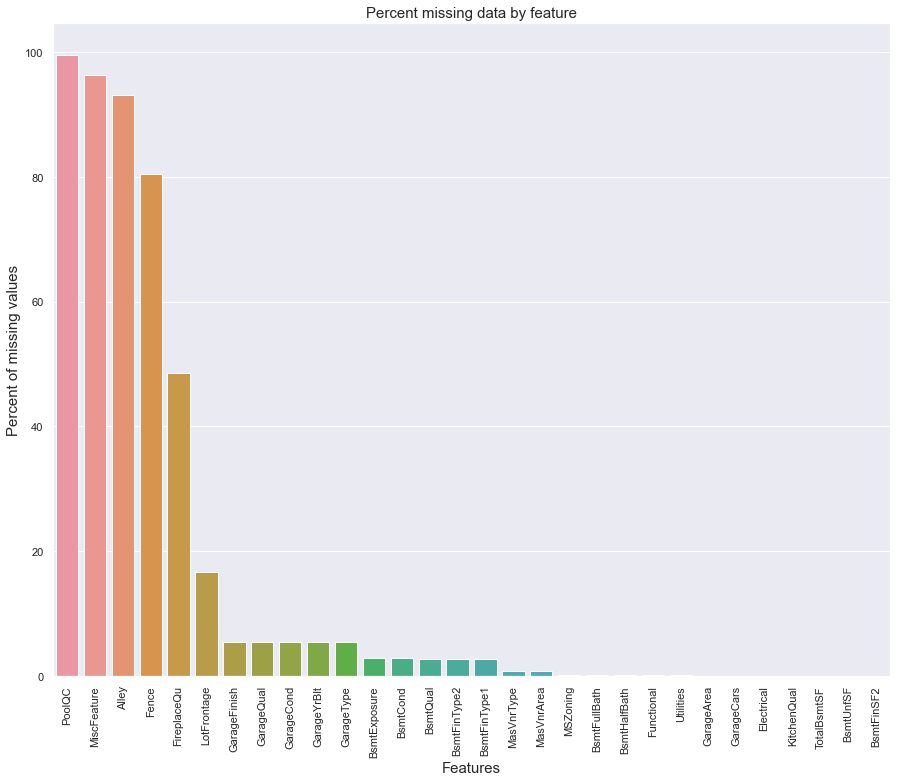

In [76]:
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

According to this, there is a set of variables (e.g. 'PoolQC', 'MiscFeature', 'Alley', etc.) that have too much data missing (over 40%) that we should ignore. Moreover, None of these variables seem to be very important, since most of them are not aspects in which we think about when buying a house. 

## 3. Features engeneering

### 3.1.Dealing with missing data

In [82]:
# Impute missing categorical values
all_data["PoolQC"] = all_data["PoolQC"].fillna("None")
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")
all_data["Alley"] = all_data["Alley"].fillna("None")
all_data["Fence"] = all_data["Fence"].fillna("None")
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna('None')
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["Functional"] = all_data["Functional"].fillna("Typ")
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])
all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")
# Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)
    
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)
    
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)


### 3.2. Transform numerical to categorical

In [83]:
#MSSubClass=The building class
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)

#Changing OverallCond into a categorical variable
all_data['OverallCond'] = all_data['OverallCond'].astype(str)

#Year and month sold are transformed into categorical features.
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

### 3.3. Include "TotalSF" feature

In [84]:
# Adding total sqfootage feature 
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

### 3.4. Transform skewed numerical data

In [87]:
#log transform the target:
train["SalePrice"] = np.log1p(train["SalePrice"])
#log transform skewed numeric features:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

### 3.5. Encode and extract dummies from categorical features

In [89]:
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')

# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

In [90]:
all_data = pd.get_dummies(all_data)

## 4.Model

In [93]:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]

y = train.SalePrice

**Ensemble**

In [98]:
# Import Ensemble models
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from mlxtend.regressor import StackingRegressor

# Metrics for root mean squared error
from sklearn.metrics import mean_squared_error
from math import sqrt
# Initialize models
lr = LinearRegression(
    n_jobs = -1
)

rd = Ridge(
    alpha = 4.84
)

rf = RandomForestRegressor(
    n_estimators = 12,
    max_depth = 3,
    n_jobs = -1
)

gb = GradientBoostingRegressor(
    n_estimators = 40,
    max_depth = 2
)

nn = MLPRegressor(
    hidden_layer_sizes = (90, 90),
    alpha = 2.75
)

# Initialize Ensemble
model = StackingRegressor(
    regressors=[rf, gb, nn, rd],
    meta_regressor=lr
)

# Fit the model on our data
model.fit(X_train, y)

StackingRegressor(meta_regressor=LinearRegression(n_jobs=-1),
                  regressors=[RandomForestRegressor(max_depth=3,
                                                    n_estimators=12,
                                                    n_jobs=-1),
                              GradientBoostingRegressor(max_depth=2,
                                                        n_estimators=40),
                              MLPRegressor(alpha=2.75,
                                           hidden_layer_sizes=(90, 90)),
                              Ridge(alpha=4.84)])

In [99]:
# Predict training set
y_pred = model.predict(X_train)
print(sqrt(mean_squared_error(y, y_pred)))

0.10222247650821822


In [100]:
# Predict test set
Y_pred = model.predict(X_test)

In [101]:
# Create empty submission dataframe
sub = pd.DataFrame()

# Insert ID and Predictions into dataframe
sub['Id'] = test['Id']
sub['SalePrice'] = np.expm1(Y_pred)

# Output submission file
sub.to_csv('submission.csv',index=False)